# Credit-scoring 

In [2]:
import warnings
import numpy as np
import pandas as pd
from datetime import datetime

from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

import os
for dirname, _, filenames in os.walk('kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
warnings.filterwarnings("ignore")

kaggle\input\sf-dst-scoring\sample_submission.csv
kaggle\input\sf-dst-scoring\test.csv
kaggle\input\sf-dst-scoring\train.csv


In [3]:
RANDOM_SEED = 42


# Импорт и просмотр данных
df_train = pd.read_csv(r'.\kaggle\input\sf-dst-scoring\train.csv')
df_test = pd.read_csv(r'.\kaggle\input\sf-dst-scoring\test.csv')

In [4]:
df_train

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


In [5]:
# Пробежимся по количеству встречающихся значений по всем признакам
df_train.nunique().sort_values()

default                 2
foreign_passport        2
car_type                2
car                     2
good_work               2
sex                     2
home_address            3
work_address            3
sna                     4
first_time              4
education               5
region_rating           7
decline_app_cnt        21
bki_request_cnt        38
age                    52
app_date              120
income                966
score_bki           69096
client_id           73799
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_train.describe(include='object')

,app_date,education,sex,car,car_type,foreign_passport
count,73799,73492,73799,73799,73799,73799
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1018,38860,41562,49832,59791,62733


In [8]:
df_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [10]:
df_test.describe(include='object')

,app_date,education,sex,car,car_type,foreign_passport
count,36349,36178,36349,36349,36349,36349
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,473,19138,20274,24458,29349,30988


In [11]:
df_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

В исходных данных 19 признаков:<br>
1 временной, типа str ('app_date'),<br>
6 бинарных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'),<br>
6 категориальных ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')<br>
6 числовых ('client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income').<br>

Пропуски встречаются только в признаке 'education' - (в df_train - 307 пропусков, в df_test - 171 пропуск).

client_id - числовой идентификационный признак, можно удалить из рассмотрения.<br>
default - целевая переменная, есть только в тренировочных данных.

Описание признаков
   client_id - идентификатор клиента
   
    education - уровень образования
    
    sex - пол заемщика
    
    age - возраст заемщика
    
    car - флаг наличия автомобиля
    
    car_type - флаг автомобиля иномарки
    
    decline_app_cnt - количество отказанных прошлых заявок
    
    good_work - флаг наличия “хорошей” работы
    
    bki_request_cnt - количество запросов в БКИ
    
    home_address - категоризатор домашнего адреса
    
    work_address - категоризатор рабочего адреса
    
    income - доход заемщика
    
    foreign_passport - наличие загранпаспорта
    
    sna - связь заемщика с клиентами банка
    
    first_time - давность наличия информации о заемщике
    
    score_bki - скоринговый балл по данным из БКИ
    
    region_rating - рейтинг региона
    
    app_date - дата подачи заявки
    
    default - флаг дефолта по кредиту
    

### Анализ и предобработка признаков

#### default  - target

0    64427
1     9372
Name: default, dtype: int64

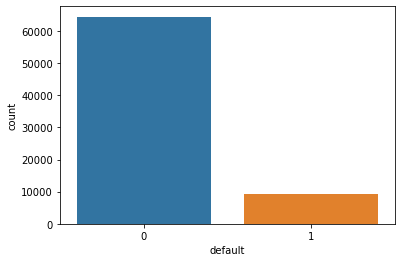

In [12]:
sns.countplot(x='default', data=df_train)
df_train.default.value_counts()
# распределение классов - сильно несбаланисованное и недефолтных клиентов заметно больше.

#### client_id

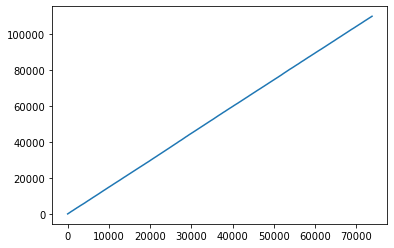

In [13]:
plt.plot(df_train['client_id'].sort_values().values)

номер клиента - удаляем из списка рассматриваемых признаков


#### education

<AxesSubplot:xlabel='education', ylabel='count'>

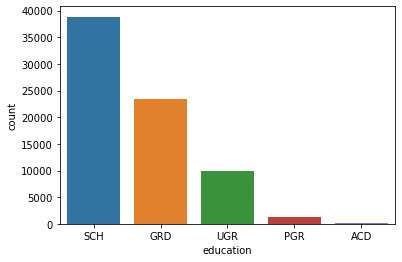

In [14]:
# Рассмотрим подробнее столбец education
sns.countplot(df_train['education'])

In [15]:
# Заполним пропуски в столбце education
df_train.education.fillna(df_train.education.mode()[0], inplace=True)
df_test.education.fillna(df_train.education.mode()[0], inplace=True)
# Ввиду малого числа значений класса 'ACD' переведем их в ближайший по смыслу класс 'PGR'
df_train.education = df_train.education.apply(
    lambda x: 'PGR' if x == 'ACD' else x)
df_test.education = df_test.education.apply(
    lambda x: 'PGR' if x == 'ACD' else x)

#### app_date

In [16]:


type(df_train.app_date.values[0])

str

<AxesSubplot:xlabel='app_date', ylabel='default'>

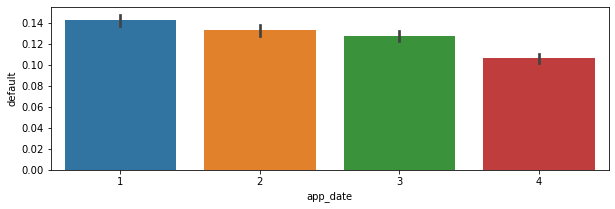

In [17]:
# Переведем str to datetime
df_train.app_date = pd.to_datetime(df_train.app_date)
df_test.app_date = pd.to_datetime(df_test.app_date)
# Посмотрим на связь месяца подачи заявки и наступления дефолта
plt.subplots(figsize=(10, 3))
sns.barplot(data=df_train, x=df_train.app_date.dt.month, y='default')

In [18]:
# Введем дополнительный признак - месяц подачи заявки

df_train['app_month'] = df_train['app_date'].dt.month
df_test['app_month'] = df_test['app_date'].dt.month

# так как нет четкого представления почему апрель лучше января - лучше кодировать через dummies
#df_train = pd.get_dummies(df_train, columns=['app_month'], drop_first=True)
#df_test = pd.get_dummies(df_test, columns=['app_month'], drop_first=True)

# Удалим ненужный строковый столбец app_date
df_train.drop(columns=['app_date'], inplace=True)
df_test.drop(columns=['app_date'], inplace=True)

In [19]:
# объединим все полученные признаки по категориям


# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'app_month', 'region_rating']

# числовые переменные
num_cols = ['age', 'decline_app_cnt',
            'score_bki', 'bki_request_cnt',  'income']

### Визуализация

#### Числовые признаки

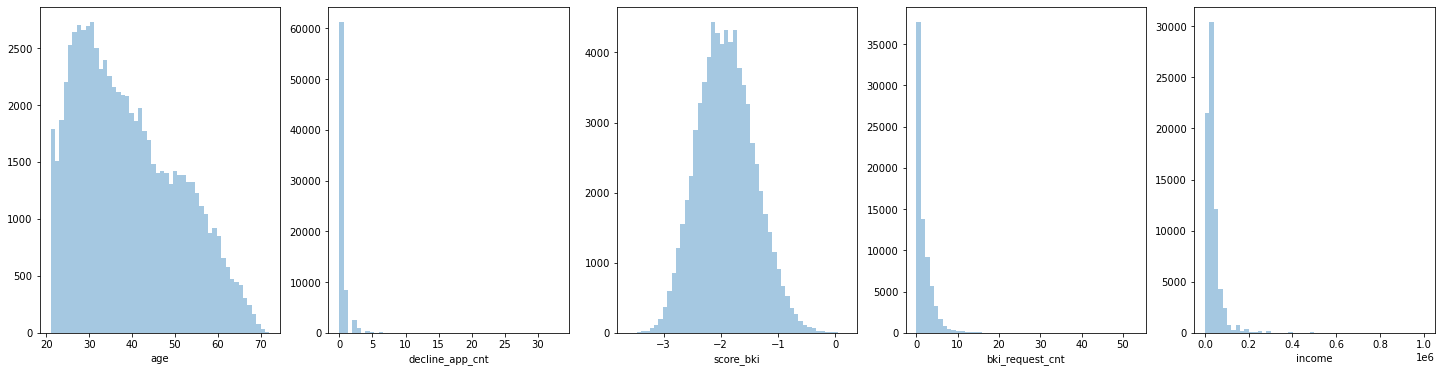

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(25, 6))
for col, i in zip(num_cols, range(len(num_cols))):
    sns.distplot(df_train[col], kde=False, ax=axes.flat[i])

Все, кроме score_bki, распределены не нормально. 
#### Попробуем прологарифмировать их:

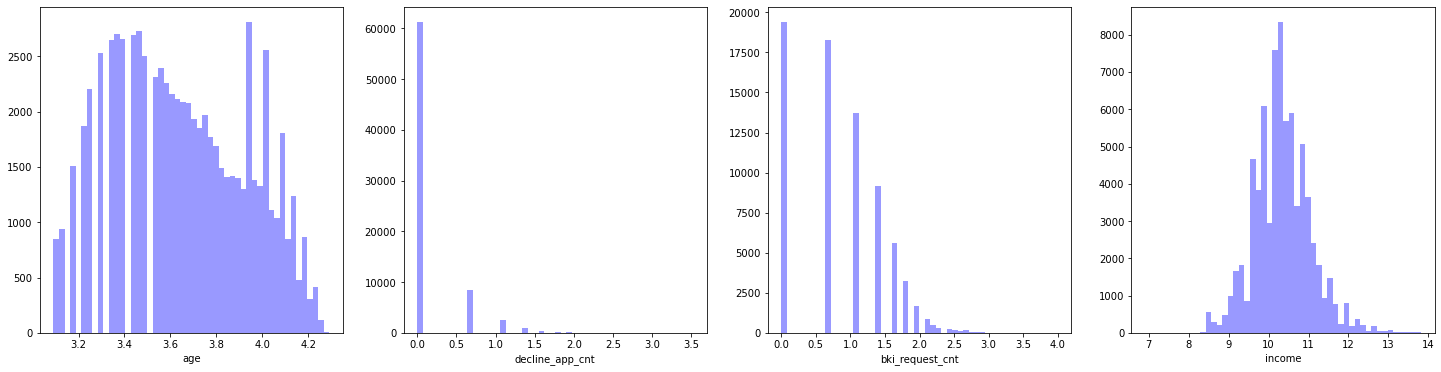

In [21]:
num_cols.remove('score_bki')
fig, axes = plt.subplots(1, 4, figsize=(25, 6))
for col, i in zip(num_cols, range(len(num_cols))):
    df_train[col] = np.log(df_train[col]+1)
    df_test[col] = np.log(df_test[col]+1)
    sns.distplot(df_train[col], kde=False, ax=axes.flat[i], color='b')
num_cols.append('score_bki')

#### Построим матрицу корреляций:

<AxesSubplot:>

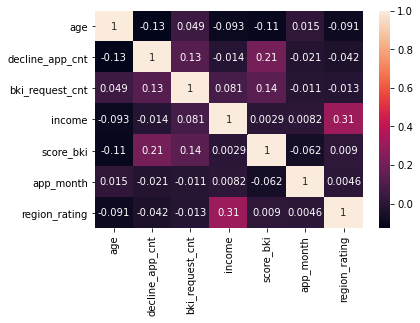

In [22]:
# Можно добавить еще два порядковых признака
num_cols_ = num_cols+['app_month', 'region_rating']

sns.heatmap(df_train[num_cols_].corr(), annot=True)

Существенных корреляций между признаками не наблюдается

#### Построим boxplot’ы для численных переменных:

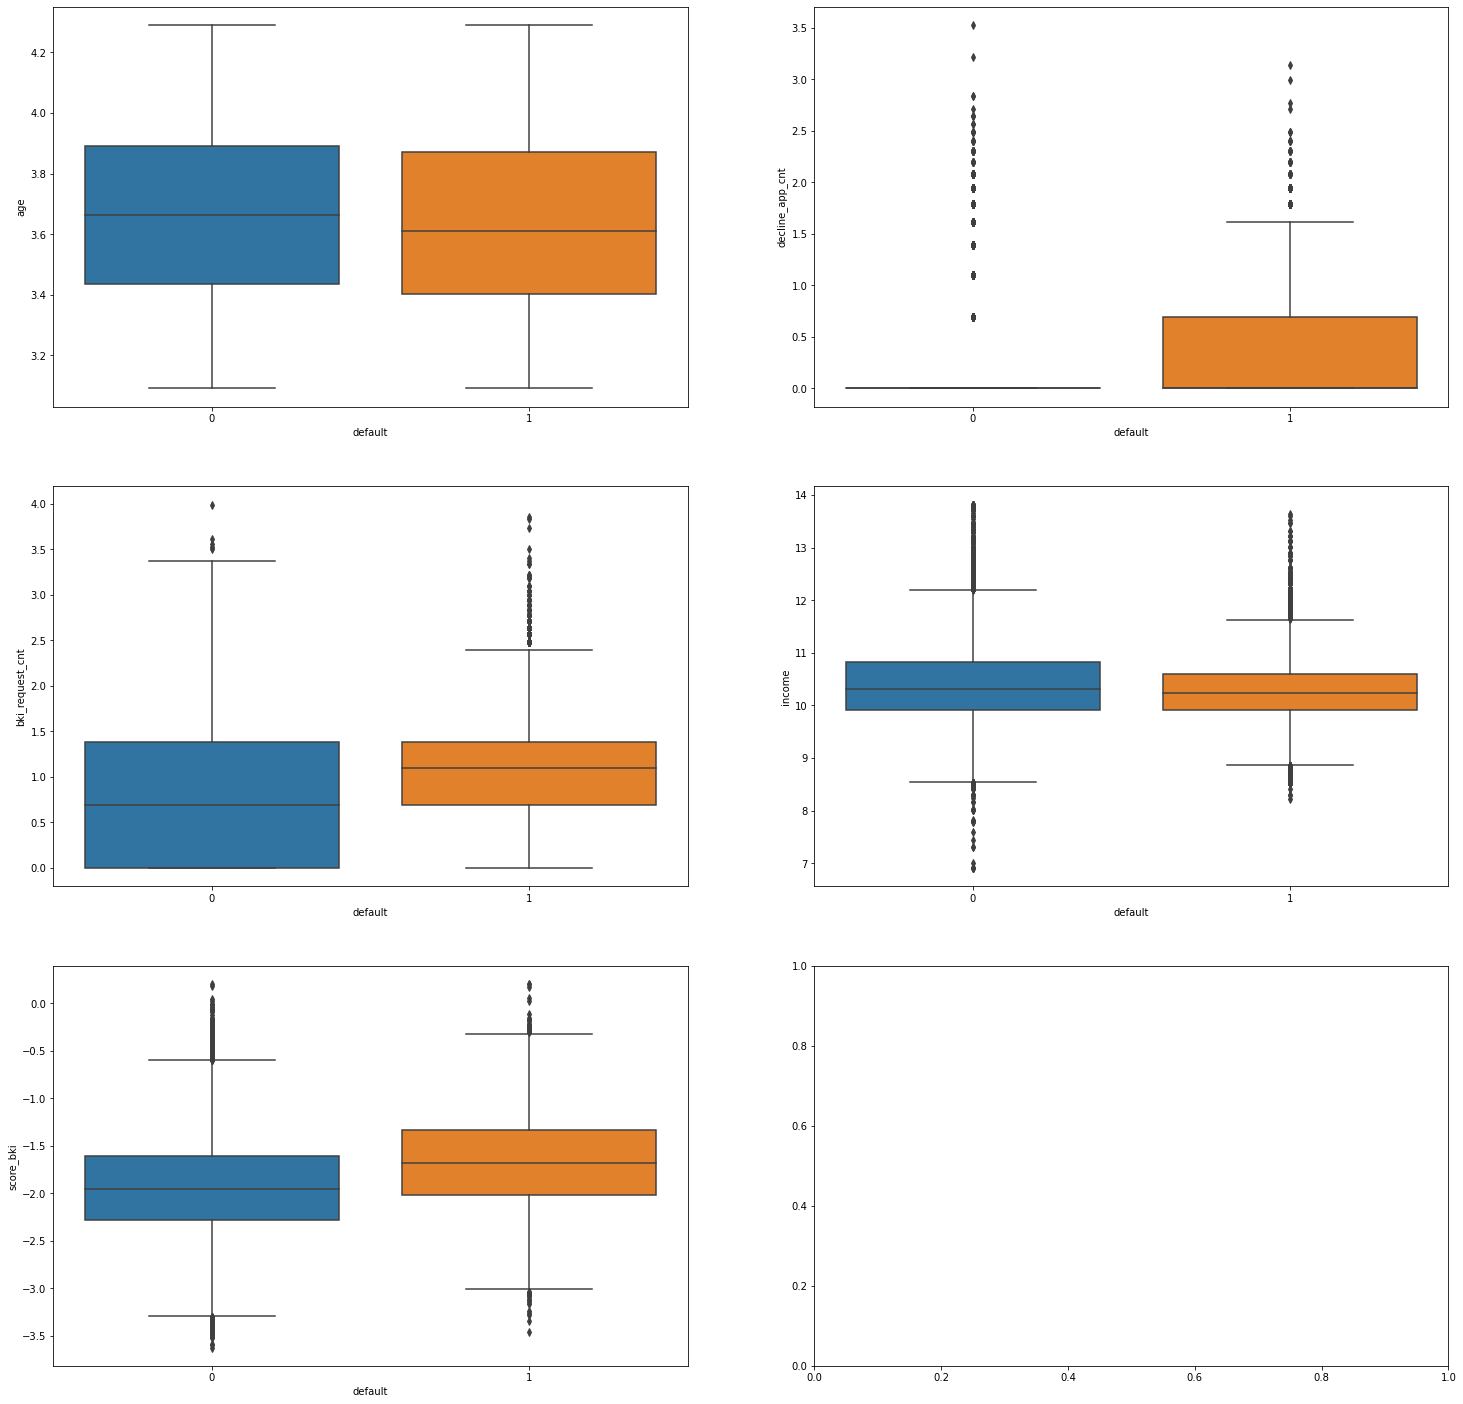

In [23]:
fig, axes = plt.subplots(3, 2, figsize=(25, 25))
for col, i in zip(num_cols, range(len(num_cols))):
    sns.boxplot(x='default', y=col, data=df_train, ax=axes.flat[i])

1. Недефолтные клиенты в среднем старше дефолтных <br>
2. У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных<br>
3. У дефолтных клиентов количество запросов выше, чем у недефолтных<br>
4. Скоринговый балл в среднем выше у дефолтных клиентов!!!<br>
5. Доход недефолтных клиентов несколько выше, чем доход дефолтных<br>
6. Везде, кроме столбца age, имеются выбросы.

### Значимость непрерывных переменных

<AxesSubplot:title={'center':'Значимость числовых переменных'}>

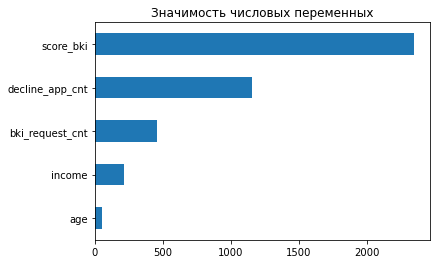

In [24]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых переменных')

### Значимость бинарных и категориальных переменных

#### Преобразование бинарных и категориальных переменных

In [25]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.transform(df_test[column])

# Переведем текстовые категории столбца education в числовые значения
df_train['education'] = label_encoder.fit_transform(df_train['education'])
df_test['education'] = label_encoder.transform(df_test['education'])

# убедимся в преобразовании
display(df_test[bin_cols].head())

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


<AxesSubplot:title={'center':'Значимость бинарных и категориальных признаков'}>

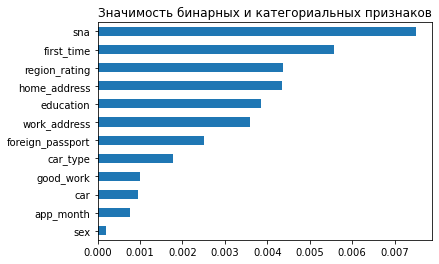

In [26]:
imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(
    kind='barh', title='Значимость бинарных и категориальных признаков')

In [27]:
df_train.describe()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,app_month
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,1.480142,0.436822,3.655332,0.324760,0.189813,0.152451,0.164894,-1.904724,0.878014,56.725701,1.575509,2.496280,10.345886,1.733330,2.765458,0.149948,0.126994,2.537053
std,31841.921168,1.071843,0.495996,0.285077,0.468288,0.392156,0.362971,0.371087,0.498231,0.657881,13.055717,0.527631,0.689818,0.697702,1.123622,1.009463,0.357023,0.332968,1.089098
min,1.000000,0.000000,0.000000,3.091042,0.000000,0.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,6.908755,1.000000,1.000000,0.000000,0.000000,1.000000
25%,27440.500000,0.000000,0.000000,3.433987,0.000000,0.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,9.903538,1.000000,2.000000,0.000000,0.000000,2.000000
50%,55274.000000,2.000000,0.000000,3.637586,0.000000,0.000000,0.000000,0.000000,-1.920823,0.693147,50.000000,2.000000,3.000000,10.308986,1.000000,3.000000,0.000000,0.000000,3.000000
75%,82758.500000,2.000000,1.000000,3.891820,1.000000,0.000000,0.000000,0.000000,-1.569831,1.386294,60.000000,2.000000,3.000000,10.778977,2.000000,4.000000,0.000000,0.000000,3.000000
max,110147.000000,3.000000,1.000000,4.290459,1.000000,1.000000,3.526361,1.000000,0.199773,3.988984,80.000000,3.000000,3.000000,13.815512,4.000000,4.000000,1.000000,1.000000,4.000000


In [28]:
df_test.describe()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,app_month
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,1.488872,0.442241,3.652950,0.327134,0.192578,0.149054,0.166772,-1.904152,0.880251,56.802938,1.573798,2.501087,10.345602,1.728053,2.765798,0.147487,2.531156
std,31706.052195,1.071772,0.496659,0.285005,0.469173,0.394329,0.357972,0.372777,0.501764,0.660265,13.086646,0.527428,0.683227,0.694477,1.120686,1.011560,0.354595,1.084800
min,4.000000,0.000000,0.000000,3.091042,0.000000,0.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,6.908755,1.000000,1.000000,0.000000,1.000000
25%,27744.000000,0.000000,0.000000,3.433987,0.000000,0.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,9.903538,1.000000,2.000000,0.000000,2.000000
50%,54657.000000,2.000000,0.000000,3.637586,0.000000,0.000000,0.000000,0.000000,-1.920823,0.693147,50.000000,2.000000,3.000000,10.308986,1.000000,3.000000,0.000000,3.000000
75%,82322.000000,2.000000,1.000000,3.891820,1.000000,0.000000,0.000000,0.000000,-1.563957,1.386294,60.000000,2.000000,3.000000,10.778977,2.000000,4.000000,0.000000,3.000000
max,110148.000000,3.000000,1.000000,4.276666,1.000000,1.000000,3.433987,1.000000,0.188820,3.871201,80.000000,3.000000,3.000000,13.815512,4.000000,4.000000,1.000000,4.000000


## Подготовка к ML

In [29]:
# Пробежимся по количеству встречающихся значений по всем категориальным признакам

print('Число категориальных признаков после OneHot кодирования должно быть: ',
      df_train[cat_cols].nunique().sum()-len(cat_cols))
df_train[cat_cols].nunique().sort_values()

Число категориальных признаков после OneHot кодирования должно быть:  22


home_address     3
work_address     3
education        4
sna              4
first_time       4
app_month        4
region_rating    7
dtype: int64

#### Преобразуем категориальные переменные при помощи OneHotEncoder:

In [30]:
oh_encoder = OneHotEncoder(sparse=False, drop='first').fit(df_train[cat_cols])
X_cat_train = oh_encoder.transform(df_train[cat_cols].values)
X_cat_test = oh_encoder.transform(df_test[cat_cols].values)
print(X_cat_train.shape)
print(X_cat_test.shape)

(73799, 22)
(36349, 22)


#### Дополним автоматически полиномиальные признаки :

In [31]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_num_train = poly.fit_transform(df_train[num_cols].values)
X_num_test = poly.transform(df_test[num_cols].values)


### Нормирование данных

In [32]:
#X_num_train = df_train[num_cols].values
#X_num_test = df_test[num_cols].values

In [33]:
# Поскольку в данных выбросы, воспользуемся RobustScaler
rscaler = RobustScaler().fit(X_num_train)
X_num_train = rscaler.transform(X_num_train)
X_num_test = rscaler.transform(X_num_test)


### ML

In [34]:
# Объединяем

# тренировочные данные 
X = np.hstack([X_num_train, df_train[bin_cols].values, X_cat_train])
y = df_train['default'].values

# тестовые данные
test_data = np.hstack([X_num_test, df_test[bin_cols].values, X_cat_test])

Из X выделяем данные на валидацию (имеется ввиду тестирование и получение метрик на части тренировочного датасета X перед сабмитом)


In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True)

In [36]:
stats = ['размер y', 'размер y_train', 'размер y_valid', 'Соотношение классов в \'default\' для обучения','Соотношение классов в \'default\' для валидации']
value = [len(y), len(y_train),len(y_valid),sum(y_train)/len(y_train),sum(y_valid)/len(y_valid)]
display(pd.DataFrame(
    {' ': stats, 'Значение': value}, columns=[' ', 'Значение']))


,,Значение
0,размер y,73799.000000
1,размер y_train,51659.000000
2,размер y_valid,22140.000000
3,Соотношение классов в 'default' для обучения,0.127606
4,Соотношение классов в 'default' для валидации,0.125565


Учитывая диспропорции классов в переменной 'default', подготовим данные для обучения моделей с помощью стратификации и ресемплинга:

In [37]:
# Из train выделяем данные на валидацию с учетом пропорций классов в переменной 'default'
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True, stratify=y)
stats = ['размер y', 'размер y_train_s', 'размер y_valid_s', 'Соотношение классов в \'default\' для обучения','Соотношение классов в \'default\' для валидации']
value = [len(y), len(y_train_s),len(y_valid_s),sum(y_train_s)/len(y_train_s),sum(y_valid_s)/len(y_valid_s)]
display(pd.DataFrame(
    {' ': stats, 'Значение': value}, columns=[' ', 'Значение']))

,,Значение
0,размер y,73799.000000
1,размер y_train_s,51659.000000
2,размер y_valid_s,22140.000000
3,Соотношение классов в 'default' для обучения,0.126987
4,Соотношение классов в 'default' для валидации,0.127010


In [38]:
# Учитывая дисбаланс классов проведем ресемплинг 
X_train_s_r, y_train_s_r = RandomUnderSampler(random_state=42).fit_sample(X_train_s, y_train_s)

stats = ['размер y', 'размер y_train_s_r', 'размер y_valid_s_r', 'Соотношение классов в \'default\' для обучения','Соотношение классов в \'default\' для валидации']
value = [len(y), len(y_train_s_r),len(y_valid_s),sum(y_train_s_r)/len(y_train_s_r),sum(y_valid)/len(y_valid)]
display(pd.DataFrame(
    {' ': stats, 'Значение': value}, columns=[' ', 'Значение']))

,,Значение
0,размер y,73799.000000
1,размер y_train_s_r,13120.000000
2,размер y_valid_s_r,22140.000000
3,Соотношение классов в 'default' для обучения,0.500000
4,Соотношение классов в 'default' для валидации,0.125565


In [39]:
# Соотношение классов в 'default' для обучения теперь: 
sum(y_train_s_r)/len(y_train_s_r)

0.5

In [40]:
# Соотношение классов в 'default' для валидации: 
sum(y_valid)/len(y_valid)

0.12556458897922312

#### Пробуем логистическую регрессию

In [41]:
model = LogisticRegression(random_state=RANDOM_SEED )
# Обучаем
model.fit(X_train_s_r, y_train_s_r)



LogisticRegression(random_state=42)

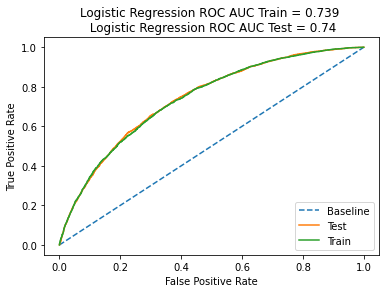

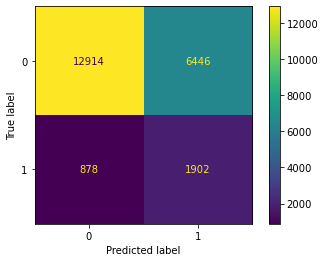

,Метрика,Значение
0,accuracy,0.669196
1,precision,0.227839
2,recall,0.684173
3,f1_score,0.341840


In [42]:
# Запускаем модель 
def get_model_metrics(model_name,model,X_train,y_train,X_valid,y_valid):
    y_pred_prob = model.predict_proba(X_valid)[:,1]
    y_pred = model.predict(X_valid)

    y_pred_prob_train = model.predict_proba(X_train)[:, 1]
    y_pred_train = model.predict(X_train)

    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_pred_prob_train)
    roc_auc_train = roc_auc_score(y_train, y_pred_prob_train)

    y_pred_prob = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Test')

    plt.plot(fpr_train, tpr_train, label='Train')
    
    plt.title(f'{model_name} ROC AUC Train = {roc_auc_train.round(3)} \n {model_name} ROC AUC Test = {roc_auc.round(3)}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    plot_confusion_matrix(model, X_valid, y_valid)
    plt.show()
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    value = [accuracy_score(y_valid, y_pred), precision_score(
        y_valid, y_pred), recall_score(y_valid, y_pred), f1_score(y_valid, y_pred)]
    display(pd.DataFrame(
        {'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение']))
    return
get_model_metrics('Logistic Regression',model,X_train_s_r,y_train_s_r,X_valid,y_valid)

#### Регуляризация

In [43]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train_s_r, y_train_s_r)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train_s_r, y_train_s_r)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 59.94842503189409


In [44]:
# Обучаем модель с полученными параметрами
model = LogisticRegression(random_state=RANDOM_SEED, penalty = 'l2', C=59.94842503189409)
model.fit(X_train_s_r, y_train_s_r)

LogisticRegression(C=59.94842503189409, random_state=42)

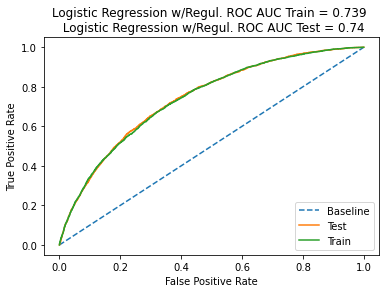

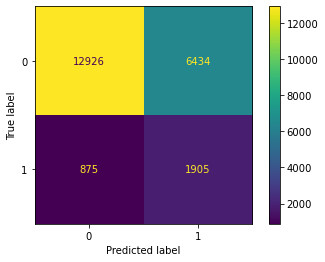

,Метрика,Значение
0,accuracy,0.669874
1,precision,0.228445
2,recall,0.685252
3,f1_score,0.342657


In [45]:
# Запускаем модель
get_model_metrics('Logistic Regression w/Regul.',model,X_train_s_r,y_train_s_r,X_valid,y_valid)

#### Поиск оптимальных значений гиперпараметров для логистической регрессии

In [51]:
# ищем оптимальные значения гиперпараметров
model = LogisticRegression(random_state=42)
param_grid = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr']}
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train_s_r, y_train_s_r)
model = gridsearch.best_estimator_
# печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
    print(param_name, best_parameters[param_name], '\n')

C 1.0 

class_weight none 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 100 

multi_class auto 

n_jobs None 

penalty l2 

random_state 42 

solver sag 

tol 0.0001 

verbose 0 

warm_start False 



#### Запускаем модель:

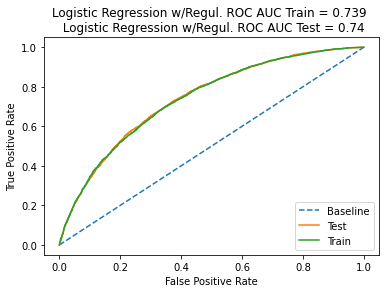

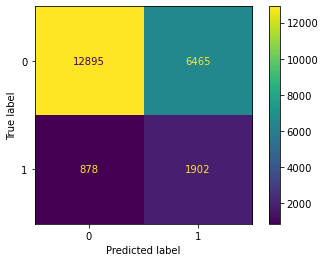

,Метрика,Значение
0,accuracy,0.668338
1,precision,0.227322
2,recall,0.684173
3,f1_score,0.341258


In [52]:
# Обучаем модель с полученными параметрами
model.fit(X_train_s_r, y_train_s_r)
# Запускаем модель
get_model_metrics('Logistic Regression w/Regul.',model,X_train_s_r,y_train_s_r,X_valid,y_valid)

# Submission

In [53]:
predict_submission = model.predict_proba(test_data)[:, 1]

submit = pd.DataFrame(df_test.client_id)
submit['default'] = predict_submission
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

,client_id,default
0,74835,0.214309
1,17527,0.765667
2,75683,0.315440
3,26883,0.368179
4,28862,0.128049
5,99881,0.558302
6,26630,0.785569
7,79934,0.196669
8,16605,0.113179
9,105449,0.138857
